In [1]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname)

In [3]:
# adp location
lon, lat = -48.401215, -27.253183

In [4]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


m = find_nearest(ds["m"], lon)
n = find_nearest(ds["n"], lat)
serie = ds.isel(m=m, n=n)

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(4, 4), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax

In [6]:
import numpy as np


bbox = ds["m"].min(), ds["m"].max(), ds["n"].min(), ds["n"].max()
bbox = [v.to_numpy() for v in bbox]

x, y = np.meshgrid(ds["m"], ds["n"])

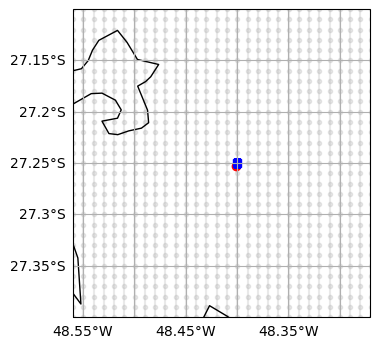

In [7]:
# %matplotlib notebook

fig, ax = creat_map(bbox=bbox)

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.plot(x, y, **kw, zorder=0);
ax.plot(lon, lat, "ro")
ax.plot(serie["longitude"], serie["latitude"], "bs")

ax.set_extent([-48.56, -48.27, -27.4, -27.1])

In [8]:
import utide


time = serie["time"].to_numpy()
u, v = serie["velocity_x"].to_numpy(), serie["velocity_y"].to_numpy()


coef = utide.solve(
    time,
    u, v,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)

In [9]:
import pandas as pd


def make_table_uv(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["Lsmaj"] = coef["Lsmaj"]
    summary["Lsmaj_ci"] = coef["Lsmaj_ci"]
    summary["Lsmin"] = coef["Lsmin"]
    summary["Lsmin_ci"] = coef["Lsmin_ci"]
    summary["theta"] = coef["theta"]
    summary["theta_ci"] = coef["theta_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="Lsmaj", ascending=False)


summary = make_table_uv(coef)

In [10]:
summary

,PE,SNR,frq,Lsmaj,Lsmaj_ci,Lsmin,Lsmin_ci,theta,theta_ci,g,g_ci
name,,,,,,,,,,,
SA,55.197713,284.172991,0.000114,0.116108,0.007778,0.004272,0.011045,114.584496,4.518751,161.018961,4.634853
M2,18.147801,11734.499288,0.080511,0.065312,0.000628,0.013136,0.001029,141.833229,1.072359,79.260173,0.667254
S2,5.755530,3373.921285,0.083333,0.036950,0.000652,0.006503,0.001085,145.876849,1.683659,79.009772,1.006262
S1,3.905182,473.152870,0.041667,0.030740,0.002326,0.003180,0.001531,37.449872,3.022170,226.046599,5.184968
SSA,3.590754,23.057843,0.000228,0.029361,0.005867,0.004010,0.010578,129.303004,21.551145,207.536165,14.237559
...,...,...,...,...,...,...,...,...,...,...,...
M8,0.000535,71.789007,0.322046,0.000343,0.000069,-0.000116,0.000048,42.411693,10.465023,105.070586,11.532522
2SK5,0.000330,9.870153,0.208447,0.000283,0.000120,-0.000019,0.000130,113.635343,30.706595,126.273919,22.903241
2MK6,0.000255,14.770508,0.244584,0.000231,0.000103,-0.000095,0.000075,50.820078,21.637710,303.793397,28.420670


In [11]:
from utide import reconstruct


tide = reconstruct(time, coef)

prep/calcs ... done.


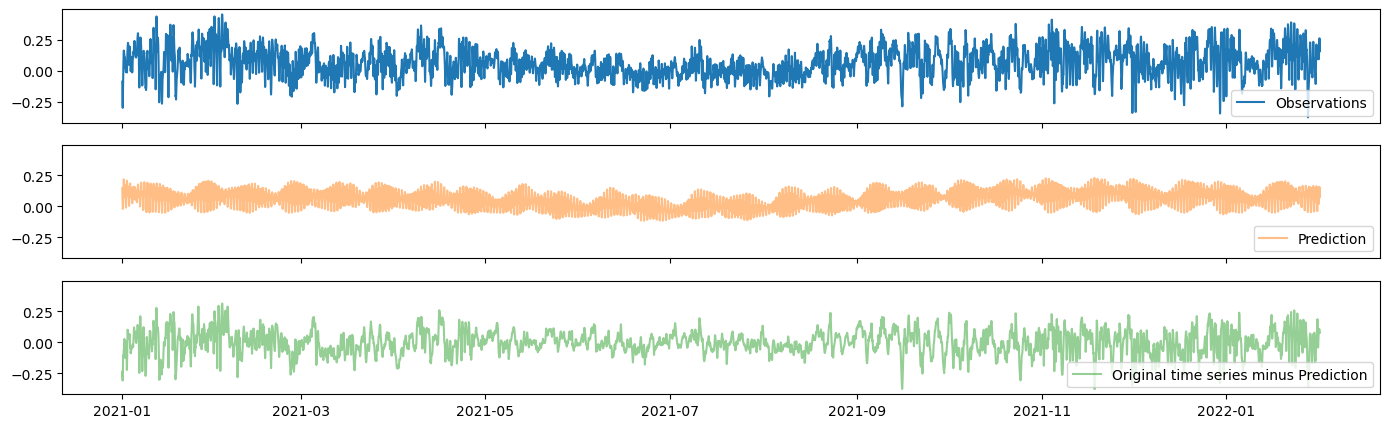

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, u, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["u"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, u-tide["u"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

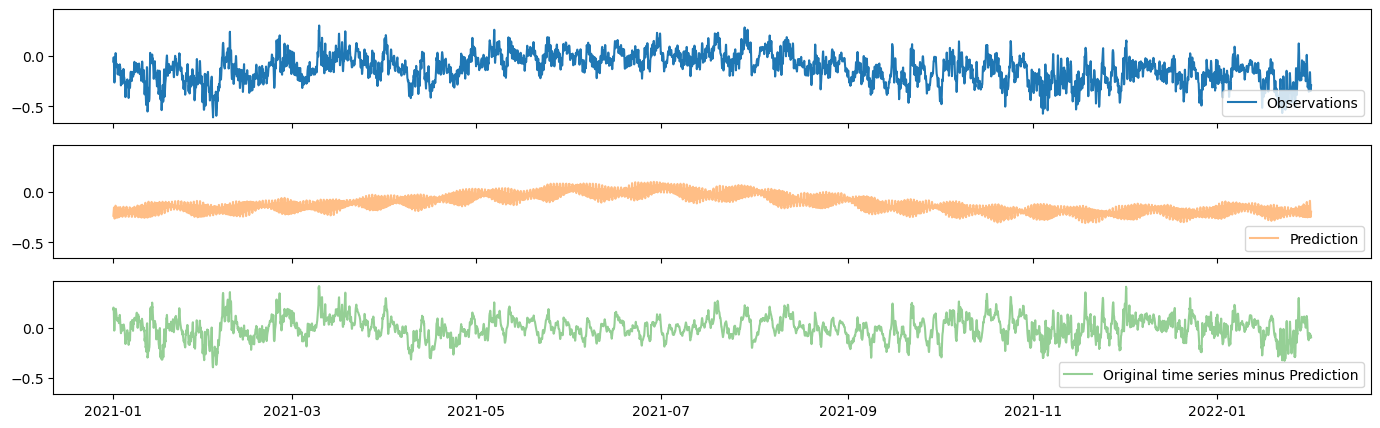

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, v, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["v"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, v-tide["v"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

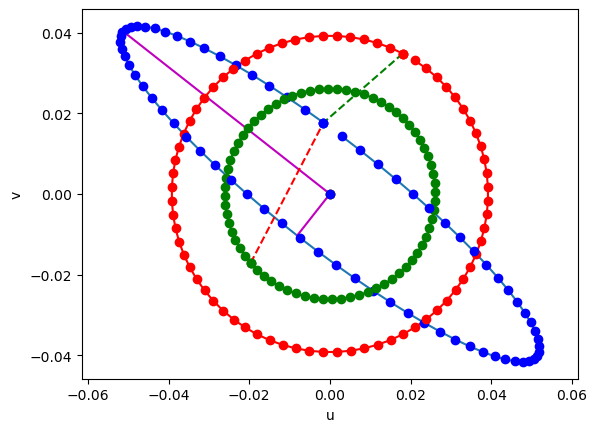

In [14]:
import tidal_ellipse


const = summary.loc["M2"]

SEMA, SEMI = const["Lsmaj"], const["Lsmin"]
PHA, INC = const["g"], const["theta"]
ECC = SEMI / SEMA

tidal_ellipse.do_the_plot(SEMA, ECC, INC, PHA)